In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from copy import copy, deepcopy

Нельзя просто так писать в терминал всё, что захочется - он предназначен только для символов. Подробнее [тут](https://stackoverflow.com/questions/47984850/pixel-control-in-terminal-with-python) и [тут](https://unix.stackexchange.com/a/146491)

Я решил воспользоваться шифром Брайля (такие проекты уже есть, но хочется попробовать самому)

В питоне они находятся по таким адресам (ord) - (10240, 10495)

In [2]:
# img = PIL.Image.open('/home/sevashasla/Pictures/fat_cat.jpg')
img = Image.open('/home/sevashasla/Pictures/angry_frog1.jpeg')
img.thumbnail((300, 300))
img = np.asarray(img)

Попытался что-то сделать через квантили, но мб лучше через контур?

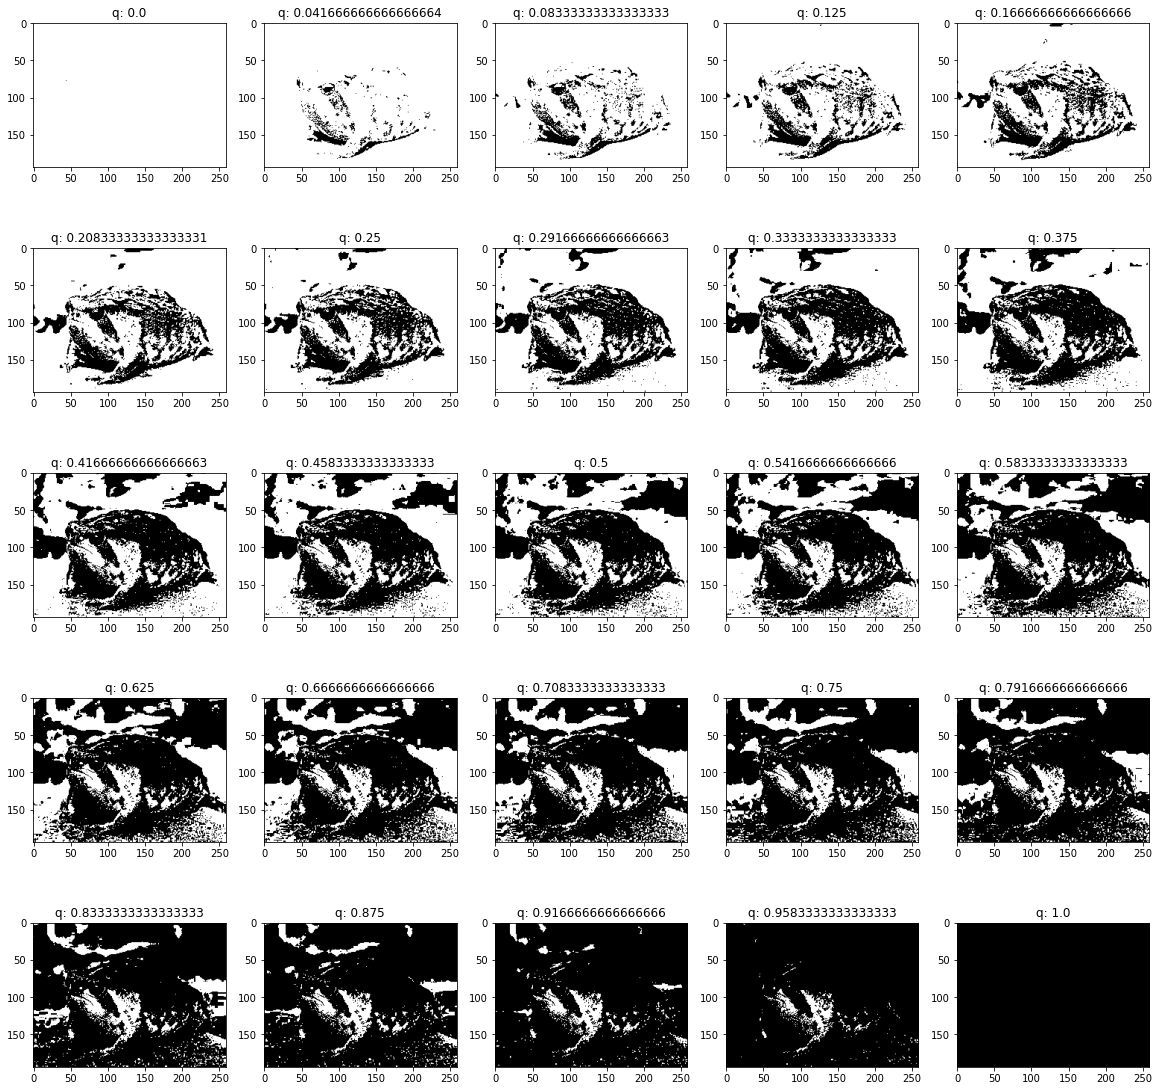

In [3]:
fig, axes = plt.subplots(5, 5)
fig.set_figwidth(20)
fig.set_figheight(20)

quantiles = np.linspace(0, 1, 25)

for i in range(5):
    for j in range(5):
        quantile = quantiles[i * 5 + j]
        axes[i, j].set_title(f'q: {quantile}')
        img_binary = ((img[:, :, 0] > np.quantile(img[:, :, 0].flatten(), quantile))).astype(np.uint8)
        axes[i, j].imshow(img_binary, cmap='gray')

In [ ]:
plt.figure(figsize=(10, 10))
plt.hist(img[:, :, 0].flatten(), bins=256);

Лучше воспользоваться более сложными алгоритмами из opencv

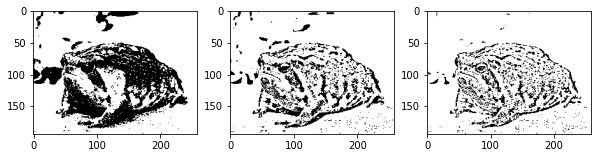

In [6]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(10)
fig.set_figheight(10)

ret, img0 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
img1 = cv2.adaptiveThreshold(img[:, :, 0], 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, 17)
img2 = cv2.adaptiveThreshold(img[:, :, 0], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 17, 17)

axes[0].imshow(img0[:, :, 0], cmap='gray')
axes[1].imshow(img1, cmap='gray')
axes[2].imshow(img2, cmap='gray')

# kernel = np.array([
#     [-1, -1, -1],
#     [-1, 8, -1],
#     [-1, -1, -1]
# ])
# dst = cv2.filter2D(img1, -1, kernel)
# plt.imshow(dst, cmap='gray')

Отлично, теперь нужно классифицировать шифр Брайля по тому, в каком месте какой пиксель горит...\
Не получилось: Можно попробовать воспользоваться [wiki](https://en.wikipedia.org/wiki/Braille_ASCII#Braille_ASCII_values)\
Однако можно перевести его в нормальный вид, человеческий:

⠁ -> 00000001\
⠂ -> 00000010\
⠄ -> 00000100\
⠈ -> 00001000\
⠐ -> 00010000\
⠠ -> 00100000\
⡀ -> 01000000\
⢀ -> 10000000

Получается, используется такая нотация (что, в целом, очень логично):
14\
25\
36\
78

In [4]:
class ImageToBraille():
    def __init__(self, image):
        self.BRAILLE_START = 10240
        self.BRAILLE_END = 10495
        self.WIDTH_STEP = 2
        self.HEIGHT_STEP = 4
        self.map4x2 = {
            (0, 0): 0,
            (1, 0): 1,
            (2, 0): 2,
            (0, 1): 3,
            (1, 1): 4,
            (2, 1): 5,
            (3, 0): 6,
            (3, 1): 7
        }
        self.pow2map4x2 = {el: 2**self.map4x2[el] for el in self.map4x2}

        self.image = copy(image)
        if self.image.shape[0] % self.HEIGHT_STEP != 0:
            need_add = self.HEIGHT_STEP - self.image.shape[0] % self.HEIGHT_STEP
            self.image = np.vstack((self.image, np.zeros((need_add, self.image.shape[1]), dtype=np.int)))

        if self.image.shape[1] % self.WIDTH_STEP != 0:
            need_add = self.WIDTH_STEP - self.image.shape[1] % self.WIDTH_STEP
            self.image = np.hstack((self.image, np.zeros((self.image.shape[0], need_add), dtype=np.int)))

    def array4x2ToSymbol(self, arr):
        result_idx = self.BRAILLE_START
        for el, power in self.pow2map4x2.items():
            result_idx += arr[el] * power
        return chr(result_idx)

    def array8x1ToSymbol(self, arr):
        result_idx = self.BRAILLE_START
        for el in arr:
            result_idx += 2 ** el
        return chr(result_idx)

    def show(self):
        for i in range(0, self.image.shape[0], self.HEIGHT_STEP):
            for j in range(0, self.image.shape[1], self.WIDTH_STEP):
                curr_arr = self.image[i:(i + self.HEIGHT_STEP), j:(j + self.WIDTH_STEP)]
                print(self.array4x2ToSymbol(curr_arr), end="")
            print()

# TEST
# arrr = np.array([
#     [0, 1],
#     [0, 1],
#     [1, 0],
#     [0, 1]
# ])
# print(ImageToBrailer(img).array4x2ToSymbol(arrr))
# arrr = np.array([2, 3, 4, 7])
# print(ImageToBrailer(img).array8x1ToSymbol(arrr))

In [ ]:
import time
import os

cap = cv2.VideoCapture('/home/sevashasla/Downloads/never_gonna.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (100, 100))
    
    gray = cv2.adaptiveThreshold(
        gray, 255, 
        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 
        5, 5
    ) // 255
    
    ImageToBraille(gray).show()

    time.sleep(0.2)
    os.system('clear')

cap.release()

In [13]:
cv2.destroyAllWindows()